In [1]:
import torch
import torchvision.transforms as tf
import pathlib
import sklearn
import numpy as np
import PIL
import matplotlib.pyplot as plt

EDA

In [2]:
np.random.seed(17)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# dogdir = "/content/drive/MyDrive/겨울코딩스터디/코딩스터디3/training_set/dogs"
# catdir = "/content/drive/MyDrive/겨울코딩스터디/코딩스터디3/training_set/cats"

dogdir = "/content/drive/MyDrive/training_set/dogs"
catdir = "/content/drive/MyDrive/training_set/cats"

In [5]:
cats, dogs = [], []
for i in pathlib.Path(catdir).iterdir():
    cats.append(i)
    
for i in pathlib.Path(dogdir).iterdir():
    dogs.append(i)

In [6]:
from sklearn.model_selection import train_test_split

cat_tr, cat_val = train_test_split(cats, test_size=0.2, random_state=17)
dog_tr, dog_val = train_test_split(dogs, test_size=0.2, random_state=17)

len(cat_tr), len(cat_val), len(dog_tr), len(dog_val)

(3200, 800, 3204, 801)

In [7]:
train_set = cat_tr + dog_tr
val_set = cat_val + dog_val

len(train_set), len(val_set)

(6404, 1601)

In [8]:
train_transforms = tf.Compose([tf.Resize((128, 128)),
                               tf.RandomHorizontalFlip(p = 0.5),
                               tf.ToTensor()])

val_transforms = tf.Compose([tf.Resize((128, 128)),
                             tf.ToTensor()])

In [9]:
from torch.utils.data import Dataset

class DogsCats(Dataset):
  def __init__(self, data, transforms):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    path = self.data[index]
    img = PIL.Image.open(path)
    img = self.transforms(img)

    if "cat" in str(self.data[index]):
      label = 0
    else:
      label = 1

    return img, label

In [10]:
train = DogsCats(train_set, train_transforms)
val = DogsCats(val_set, val_transforms)

len(train), len(val)

(6404, 1601)

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

Modeling

In [12]:
from torch import nn
import torch.nn.functional as F

class mycnn(nn.Module):
  def __init__(self):
    super(mycnn, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, 3)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 128, 3)
    self.conv5 = nn.Conv2d(128, 256, 3)

    self.bn1 = nn.BatchNorm2d(16)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(128)
    self.bn5 = nn.BatchNorm2d(256)

    self.fc = nn.Linear(1024, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)

    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)

    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)

    x = self.conv4(x)
    x = self.bn4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)

    x = self.conv5(x)
    x = self.bn5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)

    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
model = mycnn()
model.to(device)

mycnn(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [15]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), 0.001)
loss_fn = nn.CrossEntropyLoss()

In [16]:
epoch = 30
wrong = torch.tensor([])

for ep in range(epoch):

  tr_acc = 0
  tr_loss = 0
  val_acc = 0
  val_loss = 0

  for i, data in enumerate(train_loader):
    model.train()

    img, label = data
    img = img.to(device)
    label = label.to(device)

    out = model(img)
    pred = torch.argmax(out, dim=1)

    loss = loss_fn(out, label)
    tr_loss += loss
    tr_acc += (pred == label).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      img, label = data
      img = img.to(device)
      label = label.to(device)

      out = model(img)
      pred = torch.argmax(out, dim=1)

      val_loss += loss_fn(out, label)
      val_acc += (pred == label).sum().item()

      wrong = torch.cat([wrong, img[label != pred].detach().cpu()])

  print("Epoch: {},  train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}"\
        .format(ep+1, (tr_acc/len(train)), tr_loss, (val_acc/len(val)), val_loss))

Epoch: 1,  train_acc: 0.6584946908182386, train_loss: 63.491641998291016, val_acc: 0.6983135540287321, val_loss: 15.74945068359375
Epoch: 2,  train_acc: 0.7406308557151781, train_loss: 52.01455307006836, val_acc: 0.6970643347907558, val_loss: 15.676607131958008
Epoch: 3,  train_acc: 0.7846658338538414, train_loss: 46.193687438964844, val_acc: 0.7726420986883198, val_loss: 12.922240257263184
Epoch: 4,  train_acc: 0.8226108682073704, train_loss: 40.1824951171875, val_acc: 0.7857589006870705, val_loss: 11.572967529296875
Epoch: 5,  train_acc: 0.8330730793254216, train_loss: 37.64651870727539, val_acc: 0.806371018113679, val_loss: 12.004952430725098
Epoch: 6,  train_acc: 0.8588382261086821, train_loss: 32.944244384765625, val_acc: 0.7426608369768894, val_loss: 16.331375122070312
Epoch: 7,  train_acc: 0.8885071830106184, train_loss: 27.03021812438965, val_acc: 0.8082448469706434, val_loss: 10.950389862060547
Epoch: 8,  train_acc: 0.8939725171767645, train_loss: 25.90253448486328, val_acc: 0

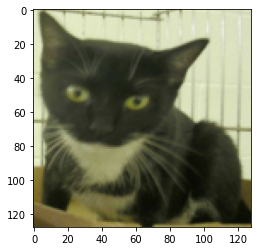

In [17]:
plt.imshow(wrong[5].permute(1, 2, 0))

ResNet34 (fine tuning x)

In [24]:
from torchvision import models
import torch

resnet34 = models.resnet34(pretrained=True)

num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 2)

resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
optimizer = optim.Adam(resnet34.parameters(), 0.001)
loss_fn = nn.CrossEntropyLoss()

In [26]:
epoch = 10

for ep in range(epoch):

  tr_acc = 0
  tr_loss = 0
  val_acc = 0
  val_loss = 0

  for i, data in enumerate(train_loader):
    resnet34.train()

    img, label = data
    img = img.to(device)
    label = label.to(device)

    out = resnet34(img)
    pred = torch.argmax(out, dim=1)

    loss = loss_fn(out, label)
    tr_loss += loss
    tr_acc += (pred == label).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  resnet34.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      img, label = data
      img = img.to(device)
      label = label.to(device)

      out = resnet34(img)
      pred = torch.argmax(out, dim=1)

      val_loss += loss_fn(out, label)
      val_acc += (pred == label).sum().item()

  print("Epoch: {},  train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}"\
        .format(ep+1, (tr_acc/len(train)), tr_loss, (val_acc/len(val)), val_loss))

Epoch: 1,  train_acc: 0.8826, train_loss: 30.1310, val_acc: 0.8832, val_loss: 7.9402
Epoch: 2,  train_acc: 0.8888, train_loss: 26.4383, val_acc: 0.9194, val_loss: 5.3239
Epoch: 3,  train_acc: 0.9427, train_loss: 14.9419, val_acc: 0.8788, val_loss: 7.5553
Epoch: 4,  train_acc: 0.9575, train_loss: 10.4377, val_acc: 0.9394, val_loss: 3.9227
Epoch: 5,  train_acc: 0.9635, train_loss: 9.1897, val_acc: 0.9250, val_loss: 5.1778
Epoch: 6,  train_acc: 0.9731, train_loss: 7.8594, val_acc: 0.9176, val_loss: 5.5459
Epoch: 7,  train_acc: 0.9725, train_loss: 7.3081, val_acc: 0.9219, val_loss: 4.9588
Epoch: 8,  train_acc: 0.9838, train_loss: 4.6853, val_acc: 0.9457, val_loss: 4.4778
Epoch: 9,  train_acc: 0.9845, train_loss: 4.1223, val_acc: 0.9182, val_loss: 7.1058
Epoch: 10,  train_acc: 0.9744, train_loss: 9.6952, val_acc: 0.8526, val_loss: 9.2845


ResNet34 (fine tuning o)

In [27]:
from torchvision import models
import torch

resnet34_fr = models.resnet34(pretrained=True)

num_ftrs = resnet34_fr.fc.in_features
resnet34_fr.fc = nn.Linear(num_ftrs, 2)

#fc layer 빼고 프리징
for name, param in resnet34_fr.named_parameters():
    if name.startswith("fc"):
        continue
    param.requires_grad = False

resnet34_fr.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
optimizer = optim.Adam(resnet34_fr.parameters(), 0.001)
loss_fn = nn.CrossEntropyLoss()

In [29]:
epoch = 10

for ep in range(epoch):

  tr_acc = 0
  tr_loss = 0
  val_acc = 0
  val_loss = 0

  for i, data in enumerate(train_loader):
    resnet34_fr.train()

    img, label = data
    img = img.to(device)
    label = label.to(device)

    out = resnet34_fr(img)
    pred = torch.argmax(out, dim=1)

    loss = loss_fn(out, label)
    tr_loss += loss
    tr_acc += (pred == label).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  resnet34_fr.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      img, label = data
      img = img.to(device)
      label = label.to(device)

      out = resnet34_fr(img)
      pred = torch.argmax(out, dim=1)

      val_loss += loss_fn(out, label)
      val_acc += (pred == label).sum().item()

  print("Epoch: {},  train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}"\
        .format(ep+1, (tr_acc/len(train)), tr_loss, (val_acc/len(val)), val_loss))

Epoch: 1,  train_acc: 0.8627, train_loss: 30.4927, val_acc: 0.9101, val_loss: 5.8334
Epoch: 2,  train_acc: 0.9093, train_loss: 21.4389, val_acc: 0.9176, val_loss: 5.2267
Epoch: 3,  train_acc: 0.9097, train_loss: 20.7926, val_acc: 0.9182, val_loss: 5.1204
Epoch: 4,  train_acc: 0.9160, train_loss: 19.0050, val_acc: 0.9188, val_loss: 4.8774
Epoch: 5,  train_acc: 0.9219, train_loss: 19.1869, val_acc: 0.9176, val_loss: 4.8951
Epoch: 6,  train_acc: 0.9222, train_loss: 20.1411, val_acc: 0.9176, val_loss: 4.8310
Epoch: 7,  train_acc: 0.9199, train_loss: 18.4678, val_acc: 0.9257, val_loss: 4.6637
Epoch: 8,  train_acc: 0.9297, train_loss: 16.9508, val_acc: 0.9232, val_loss: 4.6234
Epoch: 9,  train_acc: 0.9254, train_loss: 17.5478, val_acc: 0.9219, val_loss: 6.9480
Epoch: 10,  train_acc: 0.9290, train_loss: 17.0707, val_acc: 0.9207, val_loss: 5.2066
